# Determining the delta size

_Camu Prins_

The area of the delta is based on a method described by John Shaw in: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2008GL033963

It is based on a visual presentation of the viewing angle to the open ocean. In every point the viewing angel is calculated and when the angle is larger then 45 degrees this pixel labeled as ocean. When it is smaller, that pixel is part of the Delta.

In this Notebook, The delta is first visualised, then a binary file is created and the delinieation is explained. Summarising with a work flow that is used for the thesis.

In [39]:
# import modules
# %matplotlib inline
import matplotlib.pyplot as plt
from interactive import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import measure
from math import atan2, degrees
from scipy.spatial import cKDTree
# from math import hypot


## 1. Delta visualisation

Import and visualise the data. What delta are we working on?

In [42]:
nc_file = "Mahakam_500/Mahakam/Mahakam_delta_Netcdf/trim-001.nc"

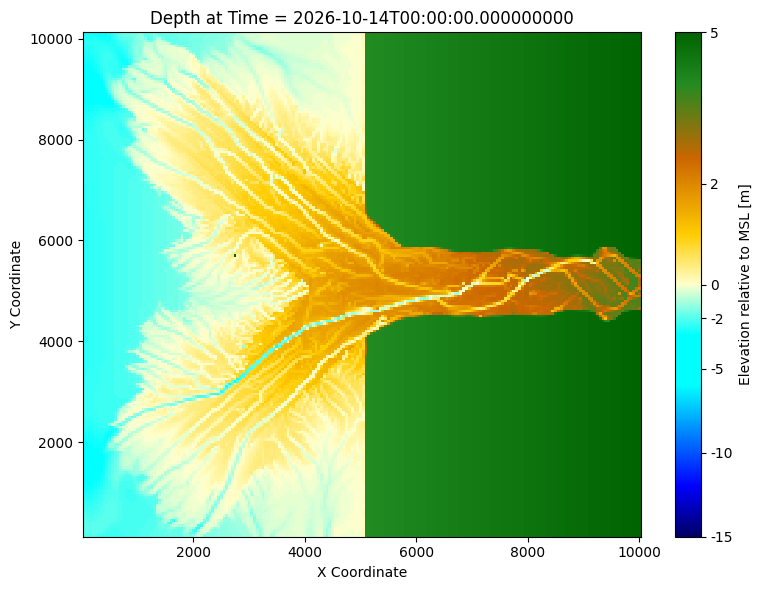

In [44]:
plot_bathymetry_with_colormap(nc_file,vmin=-15,vmax=5)

# 2. Determine delineation

## 2a. Create a binary file

A map with the classification where a pixel is either land (1) or water (0).

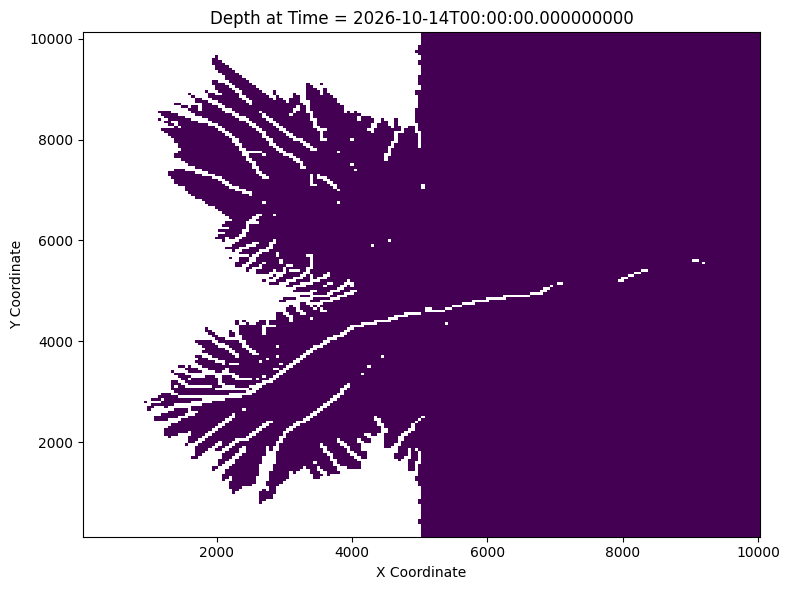

In [46]:
time_index = -1

dataset = xr.open_dataset(nc_file)

# Extract coordinates and depth data
xc = dataset["XCOR"].values[1:-1, 1:-1]
yc = dataset["YCOR"].values[1:-1, 1:-1]
depth = dataset["DPS"]
depth_inner = depth[:, 1:-1, 1:-1] * -1 

# Time values
time_values = dataset["time"].values
depth_at_t = depth_inner[time_index, :, :]

# land = np.where(depth_at_t >= 0, depth_at_t, np.nan)
landbinary = np.where(depth_at_t >= 0, 1, np.nan)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(xc, yc, landbinary)
ax.set_title(f'Depth at Time = {time_values[time_index]}')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
plt.tight_layout()
plt.show()

## 2b Determine the neigbours of a certain cell
Function that is used in the other functions to look around a cell.

In [48]:
# Compute LandWaterInterface: Pixels with one neigbouring water cell
def get_neighbors(shape, x, y):
    neighbors = [(i, j) for i in range(x-1, x+2)
                        for j in range(y-1, y+2)
                        if 0 <= i < shape[0] and 0 <= j < shape[1] and (i, j) != (x, y)]
    return neighbors # 8 location of cells arouond the cell

## 2c. Determine the land water interface (lwi)
Makes a raster with a boolean if a pixel has a cell of water next to it. Resulting in the land water interface.

In [51]:
def get_land_water_interface(binary_raster):           
    lwi = np.zeros_like(binary_raster, dtype=bool)
    land = np.argwhere(binary_raster == 1)             # gets the index of pixels with value 1
    for x, y in land:
        for i, j in get_neighbors(binary_raster.shape, x, y):   # use the get neigbours to check
            if binary_raster[i, j] == 0:
                lwi[x, y] = True
                break
    return lwi

## 2d. Compute the opening angle maps

Take the land water interface and the binary raster and produces a raster with opening angles to the shoreline. This is calculated up to 30 pixels from the shoreline.



In [117]:
def compute_opening_angle_map(binary_raster, lwi_mask, p=3, max_dist=30):
    theta_map = np.zeros_like(binary_raster, dtype=float)

    shoreline_coords = np.argwhere(lwi_mask | (binary_raster == 1))    # identy shoreline coordinates
    
    tree = cKDTree(shoreline_coords)   # Build a k-d tree for efficient spatial queries of shoreline points

    query_coords = np.argwhere((binary_raster == 0) & (~lwi_mask))     # The coords in the water where the opening angle needs to be computed 

    for idx, (xi, yi) in enumerate(query_coords):

        # Query nearby shoreline points
        nearby_idxs = tree.query_ball_point([xi, yi], r=max_dist)     # Max distance is set to 30 pixel, to prevent endless calculations over the whole domain
        if len(nearby_idxs) < 2:
            theta_map[xi, yi] = 180   # if less then 2 pixels are found, assign pixel to be fully open.
            continue                       

        angles = []
        for j in nearby_idxs:                   # Compute the angle from the point to all nearby shoreline points
            xj, yj = shoreline_coords[j]
            dx, dy = xj - xi, yj - yi
            angle = degrees(atan2(dy, dx)) % 360
            angles.append(angle)

        angles.sort()
        gaps = [(angles[(i+1) % len(angles)] - angles[i]) % 360 for i in range(len(angles))]   # compute the gap between the angles
        largest_gaps = sorted(gaps, reverse=True)[:p]    
        theta_map[xi, yi] = sum(largest_gaps)

    theta_map[binary_raster == 1] = 0
    return theta_map

## 2e. Extract the shoreline
Creates a polygon of the shoreline. Based on the opening angle map, the shoreline is extracted. The theta_c is a threshold set to determine what is counted as open ocean. Every pixel with a larger OpeningAngle is set to be open water. The blur_sigma is parameter that sets the blur of the contour. A higher sigma means more blur, and a low sigma gives more detail but noisier contours.

In [121]:
def extract_shoreline(theta_map, theta_c=90, blur_sigma=1):
    binary = theta_map > theta_c
    blurred = gaussian_filter(binary.astype(float), sigma=blur_sigma)   # Apply gaussian filter to smooth the edges of the map. 
    contours = measure.find_contours(blurred, 0.5)     # find the contours, and put in a polygon
    return contours

## 2f. Calculate area
Determing the area of a polygon, using the shoelace formula.

In [111]:
def calculate_contour_area(contour):
    """
    Calculates the signed area of a polygon using the shoelace formula.
    Assumes contour is a Nx2 array of (row, col) = (y, x) coordinates.
    """
    x = contour[:, 1]
    y = contour[:, 0]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

## 2g Plot an example

All formulas combined into a plot.

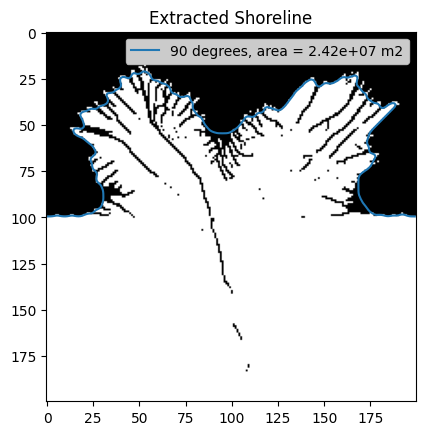

In [114]:
# Plot result
raster = np.where(depth_at_t >= 0, 1, 0)                     # Create binary file
lwi_mask = get_land_water_interface(raster)                  # Deteriment the land water interface
theta_map = compute_opening_angle_map(raster, lwi_mask, p=3) # Calculate the opening angel to the water on the lwi

plt.imshow(raster, cmap='gray')

pixel_size = 50 # meters

contours90 = extract_shoreline(theta_map, theta_c=90, blur_sigma=1.5)   # Extract the contour based on the opening angles of the lwi
area90 = calculate_contour_area(contours90[0]) * pixel_size**2          # Calcualte the area of the delta

for contour in contours90:
    plt.plot(contour[:, 1], contour[:, 0], label = f'90 degrees, area = {area90:.2e} m2')


plt.legend()    
plt.title("Extracted Shoreline")
plt.show()

# 3. Calibrate delineation paramters

## 3a. Viewing angle

Here I vary the angle that a pixel of land has to 'see' of the open ocean. I vary between 45, 90 and 120 degrees and visualise in a plot.

In [71]:
raster = np.where(depth_at_t >= 0, 1, 0)
lwi_mask = get_land_water_interface(raster)
theta_map = compute_opening_angle_map(raster, lwi_mask, p=3)

contours90 = extract_shoreline(theta_map, theta_c=90, blur_sigma=1.5)
contours120 = extract_shoreline(theta_map, theta_c=120, blur_sigma=1.5)
contours45 = extract_shoreline(theta_map, theta_c=45, blur_sigma=1.5)

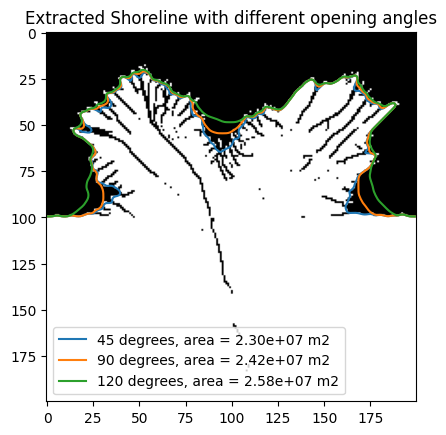

From this I am choosing the 45 dedgree opening angle, it gives the tightest fit based on the delta.


In [76]:
# Plot result
plt.imshow(raster, cmap='gray')

pixel_size = 50 # meters

area45 = calculate_contour_area(contours45[0]) * pixel_size**2
area90 = calculate_contour_area(contours90[0]) * pixel_size**2
area120 = calculate_contour_area(contours120[0]) * pixel_size**2


for contour in contours45:
    plt.plot(contour[:, 1], contour[:, 0], label = f'45 degrees, area = {area45:.2e} m2')
for contour in contours90:
    plt.plot(contour[:, 1], contour[:, 0], label = f'90 degrees, area = {area90:.2e} m2')
for contour in contours120:
    plt.plot(contour[:, 1], contour[:, 0], label = f'120 degrees, area = {area120:.2e} m2')

plt.legend()    
plt.title("Extracted Shoreline with Different Opening Angles")
plt.show()
print("From this I am choosing the 45 dedgree opening angle, it gives the tightest fit based on the delta.")

## 3b. Blur Factor

The blur factor is similar to the opening angle, a factor that determines the tightness of the contour around the area.

In [133]:
raster = np.where(depth_at_t >= 0, 1, 0)
lwi_mask = get_land_water_interface(raster)
theta_map = compute_opening_angle_map(raster, lwi_mask, p=3)

contours90_b5 = extract_shoreline(theta_map, theta_c=45, blur_sigma=0.5)
# controus90_b25 = extract_shoreline(theta_map, theta_c=45, blur_sigma=0.25)
contours90_b1 = extract_shoreline(theta_map, theta_c=45, blur_sigma=1)
# contrours90_b0 = extract_shoreline(theta_map, theta_c=45, blur_sigma=0)
contours90_b15 = extract_shoreline(theta_map, theta_c=45, blur_sigma=1.5)

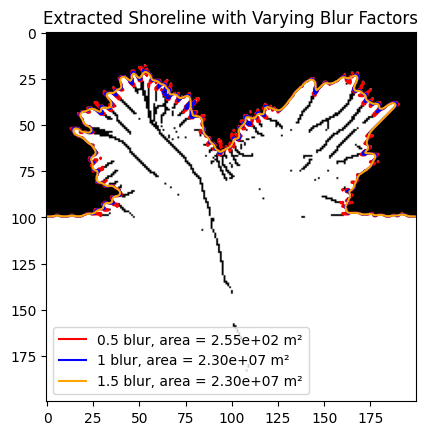

From this a blur of 1.5 is choosen. The 0.5 and 1.0 scenario, are too detailed even creating islands that are not part of the 'mainland'


In [137]:
areab5 = calculate_contour_area(contours90_b5[0]) * pixel_size**2
areab1 = calculate_contour_area(contours90_b1[0]) * pixel_size**2
areab15 = calculate_contour_area(contrours90_b15[0]) * pixel_size**2

plt.imshow(raster, cmap='gray')

for i, contour in enumerate(contours90_b5):
    label = f'0.5 blur, area = {areab5:.2e} m²' if i == 0 else None
    plt.plot(contour[:, 1], contour[:, 0], color='red', label=label)

for i, contour in enumerate(contours90_b1):
    label = f'1 blur, area = {areab1:.2e} m²' if i == 0 else None
    plt.plot(contour[:, 1], contour[:, 0], color='blue', label=label)

for i, contour in enumerate(contrours90_b15):
    label = f'1.5 blur, area = {areab15:.2e} m²' if i == 0 else None
    plt.plot(contour[:, 1], contour[:, 0], color='orange', label=label)

plt.title("Extracted Shoreline with Varying Blur Factors")
plt.legend()
plt.show()
print("From this a blur of 1.5 is selected. The 0.5 and 1.0 scenario, are too detailed even creating islands that are not part of the 'mainland'.")

# 4 Workflow

For every simulation the size of the delta is determined at each time step. This is done as presented in the loop below: 

The timesteps are taken from the shape of the dataset, in this case 549. Then the area is saved in an array and can be used for analysis.

In [ ]:
# work flow for area calc:
pixel_size = 50 # m
theta_c = 45
blur = 1.5 

# load data
dataset = xr.open_dataset(nc_file)
xc = dataset["XCOR"].values[1:-1, 1:-1]
yc = dataset["YCOR"].values[1:-1, 1:-1]
depth = dataset["DPS"][:, 1:-1, 1:-1] * -1  # Flip sign for elevation

print(depth.shape)
t2_area = []
for t in range(depth.shape[0]):
    if t % 10 == 0:
        print(f"Processing timestep {t}/{depth.shape[0]}")
    depth_at_t = depth_inner[t, :, :]
    
    raster = np.where(depth_at_t >= 0, 1, 0)
    lwi_mask = get_land_water_interface(raster)
    theta_map = compute_opening_angle_map(raster, lwi_mask, p=3)
    contours = extract_shoreline(theta_map, theta_c=theta_c, blur_sigma=blur)
    area = calculate_contour_area(contours[0]) * pixel_size**2
    
    t2_area.append(area)


(549, 200, 200)
Processing timestep 0/549
Processing timestep 10/549
Processing timestep 20/549
Processing timestep 30/549
Processing timestep 40/549
Processing timestep 50/549
Processing timestep 60/549
Processing timestep 70/549
Processing timestep 80/549
Processing timestep 90/549
Processing timestep 100/549
Processing timestep 110/549
Processing timestep 120/549
Processing timestep 130/549
Processing timestep 140/549
Processing timestep 150/549
Processing timestep 160/549
Processing timestep 170/549
Processing timestep 180/549
Processing timestep 190/549
Processing timestep 200/549
Processing timestep 210/549
Processing timestep 220/549
Processing timestep 230/549
Processing timestep 240/549
Processing timestep 250/549
Processing timestep 260/549
Processing timestep 270/549
Processing timestep 280/549
Processing timestep 290/549
Processing timestep 300/549
Processing timestep 310/549
Processing timestep 320/549
Processing timestep 330/549
Processing timestep 340/549
Processing time

In [ ]:
# started at 1217
plt.figure(figsize=(10, 3))  # Set the figure size
plt.plot(t2_area, linewidth=1, label=f'Area [m2]')  # Main line plot

plt.title('Delta area over time')
plt.xlabel('Time') 
plt.ylabel('Area [m2]') 
plt.grid(linestyle='--')
plt.legend() 
plt.tight_layout()
plt.show();

In [ ]:
dt = 1  
rate2 = np.diff(t2_area) / dt
time = np.arange(len(rate2))  # Adjust x-axis accordingly

# Plotting rate of change
plt.figure(figsize=(10, 3))
plt.plot(time, rate2, linewidth=1, label='Rate of Area Change (t2) [m²/unit time]')

plt.title('Growth Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Rate of Change [m²/unit time]')
plt.grid(linestyle='--')
plt.ylim(-100000, 400000)
plt.legend()
plt.tight_layout()
plt.show()
